# Chap07 - 베이지안 A/B 테스트

## 7.1 서론

> 가용성	테스트(split	test,	A/B	테스트,	사용성	테스트)은	전체	디자인	중	한	가지	요소를	두	가지	이상의	버전으로	실험하여	무엇이	더	나은지를	판별하는	기법입니다.	보통은	기존	버전(A)과	새로운	버전(B)를	준비하여 랜덤하게	방문하는	사용자별로	다른	버전을	보여준	후,	의도하는	결과가	높게	나오는	쪽이	어느	쪽인지를	검증한다.

## 7.2 전환율 테스트 개요

A/B 테스트의 기본적인 아이디어는 다음과 같다. 인과관계가 완벽한 세상이라고 가정할 경우, 연구 중인 두 집단은 동일하지만 어떠한 테스트에 따라 집단 간의 차이가 원인이 되어 나타난다. 하지만 실제 세계에서는 이러한 완벽한 세상에 접근할 수 없으므로 대량의 데이터를 이용하여 테스트한다.

[2장](https://render.githubusercontent.com/view/ipynb?commit=43cfc07989b3f220fe736b1887ee5fb05a1c052b&enc_url=68747470733a2f2f7261772e67697468756275736572636f6e74656e742e636f6d2f457863656c73696f72434a482f426179657369616e2d776974682d507974686f6e2f343363666330373938396233663232306665373336623138383765653566623035613163303532622f4368617030322d4d6f726550794d432f4368617030322d4d6f726550794d432e6970796e62&nwo=ExcelsiorCJH%2FBayesian-with-Python&path=Chap02-MorePyMC%2FChap02-MorePyMC.ipynb&repository_id=125394920&repository_type=Repository#2.2.2-%EC%98%88%EC%A0%9C:-%EB%B2%A0%EC%9D%B4%EC%A7%80%EC%95%88-A/B-%ED%85%8C%EC%8A%A4%ED%8A%B8)에서 다뤘던 예제를 다시 보도록 하자. 다음과 같이 A, B 사이트에대한 방문자 수와 전환된 방문자 수라고 하자.

```python
visitors_to_A = 1300
visitors_to_B = 1275

conversions_from_A = 120
conversions_from_B = 125
```

여기서 우리가 궁금한 것은 A 또는 B 사이트가 주어졌을 때의 전환확률이다. 우리의 목표는 A, B 중에서 어느 사이트의 전환확률이 높은지 알아보는 것이다. 이를 위해 A사이트 또는 B사이트가 주어진 경우 전환확률을 모델링 한다. 확률을 모델링하는 것이므로 사전확률분포로는 베타분포가 좋다(확률처럼 0과 1사이의 값으로 제한되기 때문). 방문자와 전환데이터 숫자는 이항적(discrete)이다. A 사이트의 경우 1,300번 중 120번이 성공했다. 

[6장](https://render.githubusercontent.com/view/ipynb?commit=43cfc07989b3f220fe736b1887ee5fb05a1c052b&enc_url=68747470733a2f2f7261772e67697468756275736572636f6e74656e742e636f6d2f457863656c73696f72434a482f426179657369616e2d776974682d507974686f6e2f343363666330373938396233663232306665373336623138383765653566623035613163303532622f4368617030362d5072696f7269746965732f4368617030362d5072696f72732e6970796e62&nwo=ExcelsiorCJH%2FBayesian-with-Python&path=Chap06-Priorities%2FChap06-Priors.ipynb&repository_id=125394920&repository_type=Repository#6.6-%EC%BC%A4%EB%A0%88-%EC%82%AC%EC%A0%84%ED%99%95%EB%A5%A0%EB%B6%84%ED%8F%AC)에서 알아 보았듯이 베타사전확률분포와 이항관측치(데이터)가 켤레 관계임을 알 수 있다. 즉, MCMC를 수행할 필요가 없다. 

만약 사전확률분포가 $\text{Beta} (\alpha_0, \beta_0)$ 이고 실험 $N$번, 성공 $X$개면 사후확률분포는 $\te4xt{Beta} (\alpha_0 + X, \beta_0 + N - X)이며 `SciPy`의 `beta`함수를 사용하여 사후확률분포에서 바로 표본을 추출할 수  있다.

In [1]:
visitors_to_A = 1300
visitors_to_B = 1275
conversions_from_A = 120
conversions_from_B = 125

In [2]:
from scipy.stats import beta

alpha_prior = 1
beta_prior = 1
posterior_A = beta(alpha_prior + conversions_from_A,
    beta_prior + visitors_to_A - conversions_from_A)
posterior_B = beta(alpha_prior + conversions_from_B,
    beta_prior + visitors_to_B - conversions_from_B)

In [3]:
samples = 20000 # 더 나은 근사를 위해서는 이 값이 더 커야 한다 # We want this to be large to get a better approximation.
samples_posterior_A = posterior_A.rvs(samples)
samples_posterior_B = posterior_B.rvs(samples)
print ((samples_posterior_A > samples_posterior_B).mean())

0.313


In [6]:
%matplotlib inline
from IPython.core.pylabtools import figsize
from matplotlib import pyplot as plt
import matplotlib
import numpy as np

matplotlib.rc('font', family='NanumGothic')  # Linux
figsize(12.5, 4)
plt.rcParams['savefig.dpi'] = 300
plt.rcParams['figure.dpi'] = 300

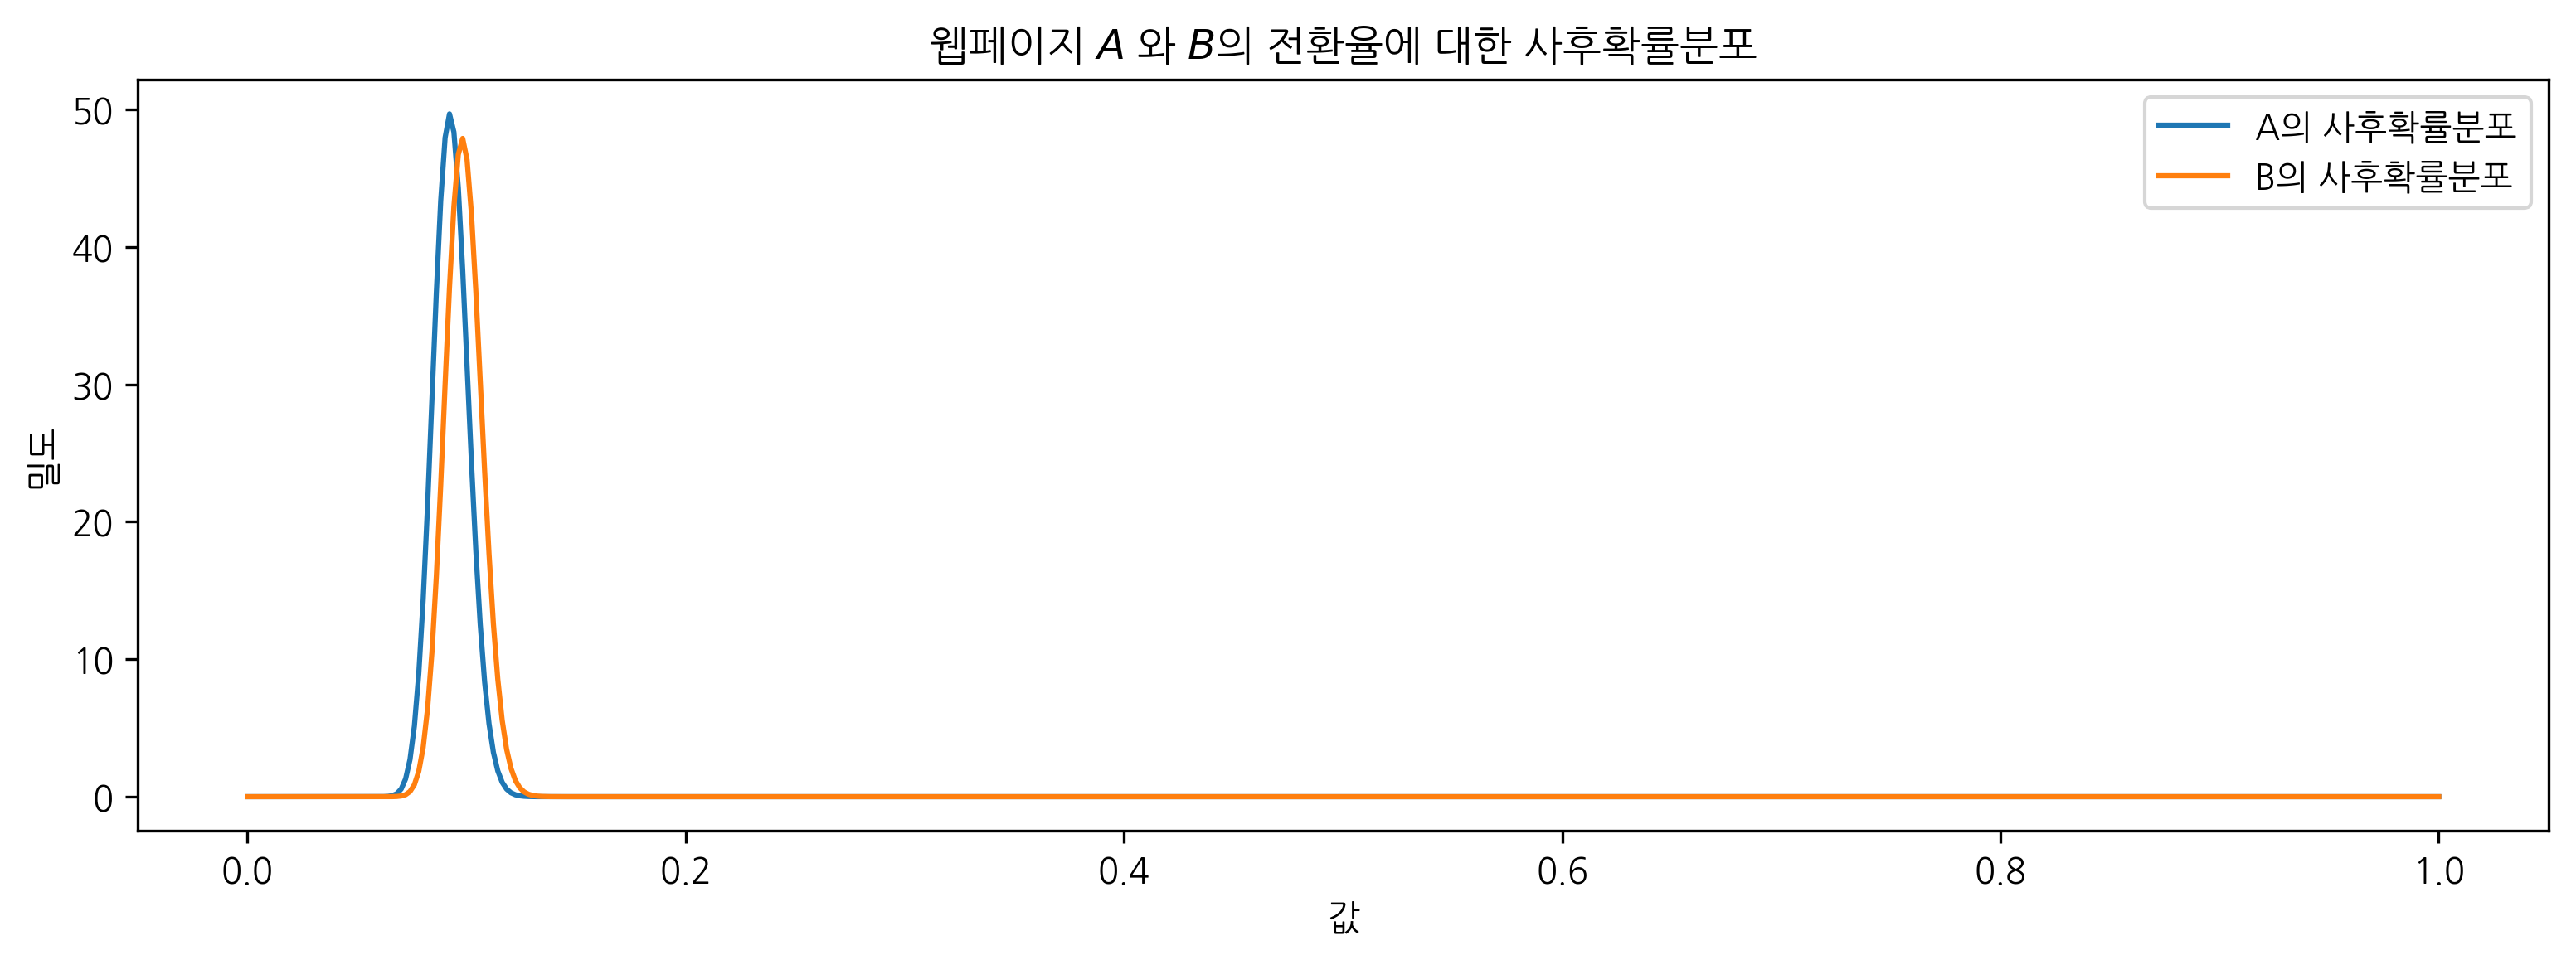

In [8]:
x = np.linspace(0,1, 500)
plt.plot(x, posterior_A.pdf(x), label='A의 사후확률분포')
plt.plot(x, posterior_B.pdf(x), label='B의 사후확률분포')
plt.xlabel('값')
plt.ylabel('밀도')
plt.title("웹페이지 $A$ 와 $B$의 전환율에 대한 사후확률분포")
plt.legend();

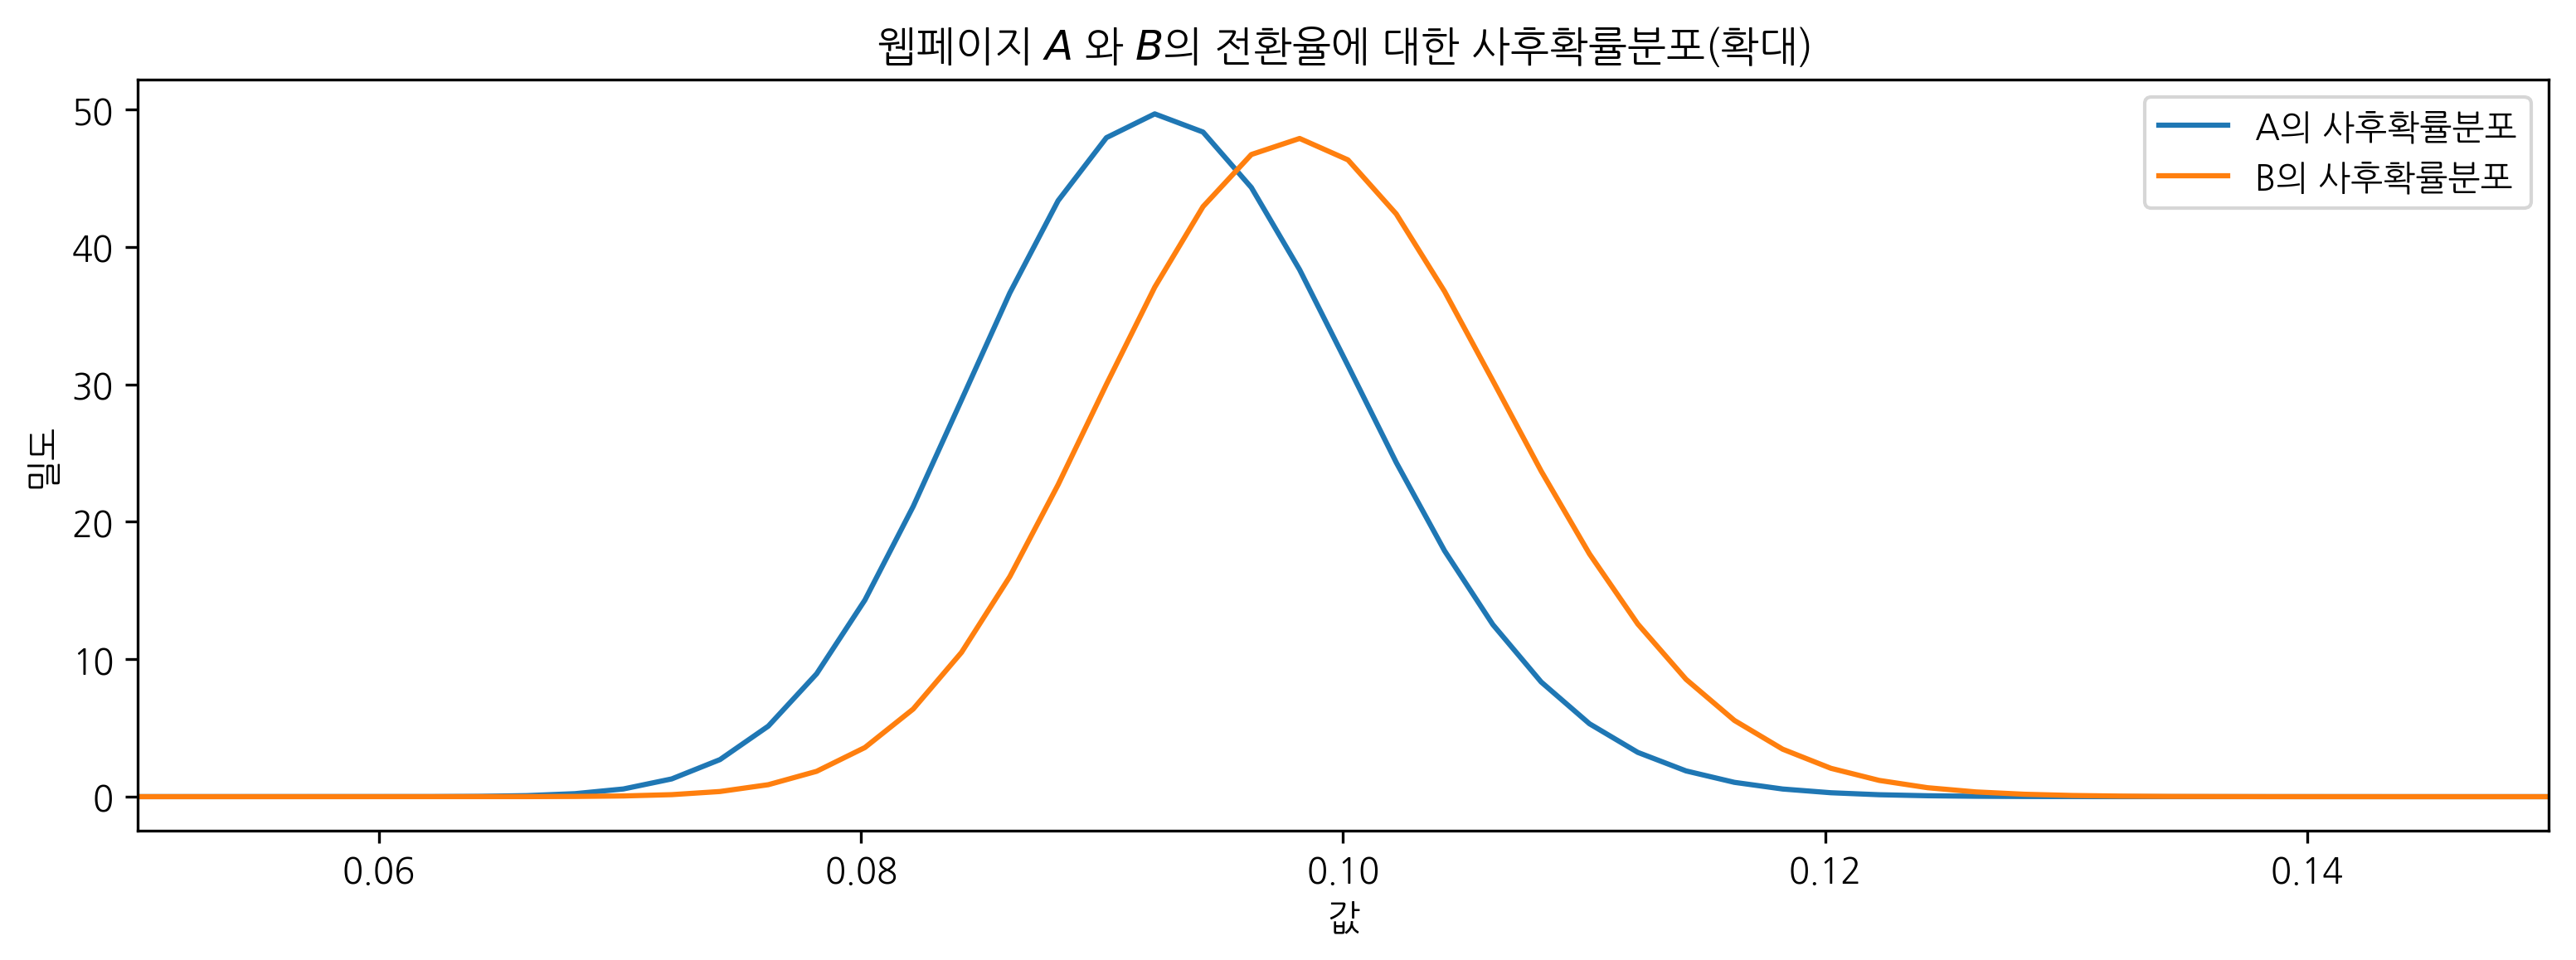

In [9]:
plt.plot(x, posterior_A.pdf(x), label='A의 사후확률분포')
plt.plot(x, posterior_B.pdf(x), label='B의 사후확률분포')
plt.xlim(0.05, 0.15)
plt.xlabel('값')
plt.ylabel('밀도')
plt.title("웹페이지 $A$ 와 $B$의 전환율에 대한 사후확률분포(확대)")
plt.legend();

## 7.3 선형손실함수 추가하기

